In [2]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import mdtraj as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

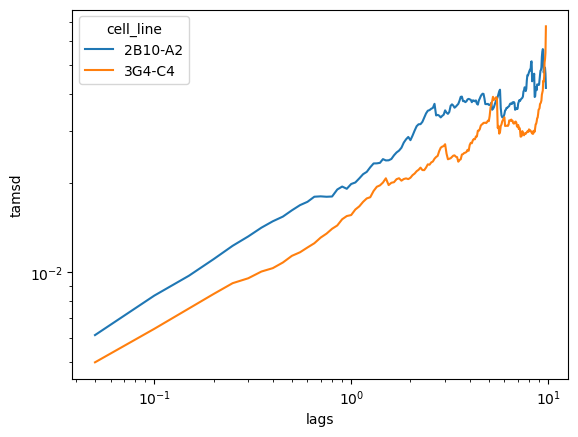

lag, s	msd, um^2
0.30	0.0087


In [2]:
df = pd.read_csv("exp_no_cohesin_no_ctcf.csv")
df_groupped = df.groupby(["lags", "cell_line"]).mean()
sns.lineplot(data=df_groupped, x="lags", y="tamsd", hue="cell_line")
plt.xscale("log")
plt.yscale("log")
plt.show()
df_groupped = df.groupby("lags").mean()
lags = df_groupped.index.to_numpy()
# subtract error 0.0025
tamsd = df_groupped.tamsd.to_numpy() - 0.0025

lag, msd = float("inf"), float("inf")
for i in range(len(lags)):
    if abs(tamsd[i] - 0.095**2) < abs(msd - 0.095**2):
        lag, msd = lags[i], tamsd[i]
print(f"lag, s\tmsd, um^2")
print(f"{lag:.2f}\t{msd:.4f}")

Different cell lines stand for different biological replicas with different insertions. There is no CTCF sites nor Loop Extrusion.

0.3 sec to travel 0.095 um (8kb)

### Load modeling data

Functions to speed up MSD calculations:

In [3]:
def autocorrFFT(x):
    N = len(x)
    F = np.fft.fft(x, n=2 * N)  # 2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res = (res[:N]).real  # now we have the autocorrelation in convention B
    n = N * np.ones(N) - np.arange(0, N)  # divide res(m) by (N-m)
    return res / n  # this is the autocorrelation in convention A


def msd_fft(r):
    N = len(r)
    D = np.square(r).sum(axis=1)
    D = np.append(D, 0)
    S2 = sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
    Q = 2 * D.sum()
    S1 = np.zeros(N)
    for m in range(N):
        Q = Q - D[m - 1] - D[N - m]
        S1[m] = Q / (N - m)
    return S1 - 2 * S2


def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

## Match time units for 2 kb, using premade arrays

In [4]:
xyz = np.load("xyz_original.npy")
cm_trajectory_2kb = np.load("xyz_coarse_grained.npy")
coarse_graining_rate = 4
msd_arr_2kb = []
msd_cm_2kb = []
for i in range(xyz.shape[1]):
    msd_arr_2kb.append(msd_fft(xyz[:, i]))
    msd_cm_2kb.append(msd_fft(cm_trajectory_2kb[:, i]))
msd_cm_aver_2kb = np.array(msd_cm_2kb).mean(axis=0)
for i, v in enumerate(np.array(msd_arr_2kb).mean(axis=0)[:5000]):
    print(i, v, msd_cm_aver_2kb[i])

0 3.53775982076561e-08 -1.0471156105938318e-14
1 0.022151612750724626 0.006232310004073246
2 0.042727288462609626 0.013007445948300313
3 0.06227809298168028 0.019652569664510854
4 0.0813250129982096 0.026226376026281622
5 0.09997731366253729 0.03274727192329339
6 0.11827552214401449 0.0392223922272248
7 0.13627068191398226 0.04565851307680341
8 0.1539526199396927 0.052052949654580516
9 0.1713375386873739 0.05841218440662631
10 0.18845012634642144 0.06473402995592444
11 0.20529351149832864 0.0710112051440424
12 0.2218950166417184 0.0772521733582742
13 0.23824968502122906 0.08345653074891557
14 0.25437948387144915 0.0896277209742583
15 0.27027665517991445 0.09577017210676786
16 0.28593366839642814 0.10188147853931857
17 0.30136114457497337 0.10796324358585557
18 0.3165819033048305 0.11401236483936827
19 0.3316006636197483 0.12003358698808149
20 0.346415551956547 0.12602903311550126
21 0.3610254404892041 0.13199673402347625
22 0.3754423025504327 0.1379356368641634
23 0.389679600446267 0.1

## If you want to use your DCD trajectory

In [5]:
coarse_graining_rate = 4
tr = md.load_dcd("traj_10.dcd.lammpstrj", top="../../1k.mol2")
tr.xyz *= 10

In [6]:
cm_trajectory_2kb = np.array(
    [moving_average(tr.xyz[i], n=coarse_graining_rate) for i in range(len(tr.xyz))]
)
msd_arr_2kb = []
msd_cm_2kb = []
for i in range(100, 900, 10):
    msd_arr_2kb.append(msd_fft(tr.xyz[10000:, i]))
    msd_cm_2kb.append(msd_fft(cm_trajectory_2kb[10000:, i]))
msd_cm_aver_2kb = np.array(msd_cm_2kb).mean(axis=0)
for i, v in enumerate(np.array(msd_arr_2kb).mean(axis=0)[:5000]):
    print(i, v, msd_cm_aver_2kb[i])

0 3.3862936277273545e-08 -1.2079226507921703e-14
1 0.02215413959226211 0.006232722746815966
2 0.04273356946438156 0.013009026006215407
3 0.06228882022673545 0.019655374687939542
4 0.0813388435150408 0.026229546612843536
5 0.09999421890523479 0.03274953561011671
6 0.11829296583517461 0.03922302337387364
7 0.13628740522437538 0.045656330624347416
8 0.15396618557659564 0.052048617565777985
9 0.17135396416167978 0.058406900343665316
10 0.188469035309884 0.06472735750037018
11 0.2053113424292981 0.07100362020107909
12 0.2219100220725309 0.07724321148121475
13 0.2382623806213026 0.08344554342788087
14 0.2543910564923131 0.08961558578478587
15 0.2702877764447621 0.09575648277152879
16 0.2859441028146314 0.10186645404729688
17 0.3013723182036124 0.10794720823851164
18 0.3165960585669566 0.11399597650977995
19 0.3316176963505534 0.12001693791405685
20 0.34643250330827796 0.1260117771922559
21 0.36104336669240167 0.13198038985536797
22 0.3754617438697565 0.13792164100456858
23 0.3896993597659097

Timeframes every 10 steps. \
For 2kb resolution we can estimate it's size as 15nm\*sqrt(10) = 47nm \
The size of 8kb segment is 15nm\*sqrt(40) = 95nm \
Physical size of 8kb twice as big as 2kb. \
When we match MSDs, since it's squared displacement we have to squared the calculated factor. We have to find when MSD reaches the value of 4 in the last column (see above) because it corresponds to average MSD of 8kb segment at the 2kb resolution. \
At 2kb, we reach the value 4 at 14790 steps that corresponds to 0.3 seconds. So 1 sec ~ 50'000 steps